<a href="https://colab.research.google.com/github/jshogland/SpatialModelingTutorials/blob/main/Notebooks/kernel_pca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estimating kernel weights using PCA and a defined analysis window
## In this notebook we will explore the use of Raster Tools and Scikit learn functions to project predictor surfaces into orthogonal space for modeling. A few key objectives of using this approach:
- Determine and use the optimal cell weights of a convolution kernel (user defined size) that can be used to transform a given raster and its bands into a subset of surfaces that explain a user specified amount of the variation in the image data.
- Efficiently create orthogonal predictor surfaces that account for band and spatial covariation.
- Create predictor surfaces that highlight various hue and textural attributes within the data.
### The approach
- Use sampling to create training sets
- Scale input rasters to unit variance
- Perform PCA on scaled training sets that include all input cell values for the cells within a user specified analysis window
- Center scaled cell values, multiply PCA score weights by centered values, and sum values within the analysis window to perform the convolution
- Optionally, rescale PCA transformed values to a specified bit depth for storage and downstream analyses

John Hogland 12/6/20024

#### Study area for this example includes portions of the Custer Gallatin Nation Forest

Install packages

In [1]:
!pip install mapclassify
!pip install osmnx
!pip install raster_tools
!pip install planetary-computer
!pip install pystac-client
!pip install stackstac

Import libraries

In [13]:
import numpy as np, os, geopandas as gpd, pandas as pd, osmnx as ox, pystac_client, planetary_computer, stackstac
from raster_tools import Raster, general
from raster_tools import raster
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


## Introduction
### Multispectral remotely sensed datasets are commonly used as predictor variables in many classification, regression, and clustering models. Often these data are highly correlated and covary across bands and x and y space. For compression, storage, and predictive modeling purposes it is often advantageous to project those data along shared axes of covariance to create independent transformed variables using principal component anlaysis (PCA). 
### In this example we explore the use of a PCA to project multispectral imagery along orthogonal axes derived from both band and neighboring cell values. Our procedure automates the selection of optimal kernel weights for multidimensional convolution kernels based on principal component scores and the proportion of the variation (information) explained by each component.

### The study area
#### Get the boundary data for portions of the Custer Gallatin National Forest and create a interactive location map of the study (Figure 1).

In [14]:
import folium
#use OpenStreetMaps to get the boundary of the NF
nf=ox.geocode_to_gdf('Custer Gallatin National Forest, MT, USA')

#get first polygon of the NF
nfe=nf.explode()
nf1=gpd.GeoSeries(nfe.geometry.iloc[10],crs=nf.crs)

#project to Albers equal area
nf1p=nf1.to_crs(5070)

#Visualize the nf1 and sample locations
m=nf1p.explore(color='red',style_kwds=dict(fill=False,weight=5))
folium.TileLayer(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Esri",
    name="Esri Imagery",
    overlay=False,
    control=True,
).add_to(m)
folium.LayerControl().add_to(m)
m

C:\Users\jshogland\AppData\Local\Temp\ipykernel_2972\4288319230.py:6: FutureWarning:

Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.



__Figure 1.__ Interactive location map of the study area.

## Methods
### To project Landsat 8 imagery to independent component surfaces (ICSs) we will implement a multistep approach.
1. Download part of a Landsat scene for the area around the Custer Gallatin Nation Forest (Figure 1) from Planetary Computer. 
2. Create convolution PCA model using a 5 by 5 analysis window.
5. Apply component scores to kernel cell values within each Landsat band. 

To perform these steps, we created a series of python functions that utilize Scikit Learn and Raster Tools application programming interface (API).


### Step 1: Get Landsat 8 Imagery
Create download definitions

In [15]:
#create definition to mosaic stac data
def mosaic_stac(xr):
    return stackstac.mosaic(xr)

#create definition to extract stac data
def get_stac_data(geo,url="https://planetarycomputer.microsoft.com/api/stac/v1",name="sentinel-2-l2a",res=30,crs=5070,**kwarg):
    '''
    gets tiled data from planetary computer as a dask backed xarray that intersects the geometry of the point, line, or polygon

    geo = (polygon) geometry bounding box (WGS84)
    url = (string) base url to planetary computer https://planetarycomputer.microsoft.com/api/stac/v1
    name = (string) catelog resource
    qry =  (dictoinary) of property values {'eo:cloud_cover':{'lt':1}}
    res = (tuple of numbers) output resolution (x,y)
    crs = (int) output crs
    dt = (string) data time intervale e.g., one month: 2023-06, range: 2023-06-02/2023-06-17
    limit = (int) max number of items to return

    returns (xarray data array and stac item catalog)
    '''
    catalog = pystac_client.Client.open(url, modifier=planetary_computer.sign_inplace)
    srch = catalog.search(collections=name, intersects=geo, **kwarg)
    ic = srch.item_collection()
    if(len(ic.items)>0):
        xra = stackstac.stack(ic,resolution=res,epsg=crs)
        xra = mosaic_stac(xra)
    else:
        xra=None

    return xra,ic


Download the data and create a raster object

In [16]:
#get stac data landsat data
if(not os.path.exists('ls82016.tif')):
    xmin,ymin,xmax,ymax=nf1p.buffer(200).total_bounds
    ls30, ic =get_stac_data(nf1.geometry[0],"https://planetarycomputer.microsoft.com/api/stac/v1",name="landsat-c2-l2",res=30,crs=5070,datetime='2016-06-15/2016-06-30',query={'eo:cloud_cover':{'lt':10},'platform':{'eq':'landsat-8'}},limit=1000)
    ls30s=Raster(ls30.sel(band=['red', 'green', 'blue','nir08', 'lwir11','swir16', 'swir22'],x=slice(xmin,xmax),y=slice(ymax,ymin)))
    ls30s=ls30s.save('ls82016.tif')

ls30s=Raster('ls82016.tif')

### Visualize the boundary and  imagery (Figure 2)

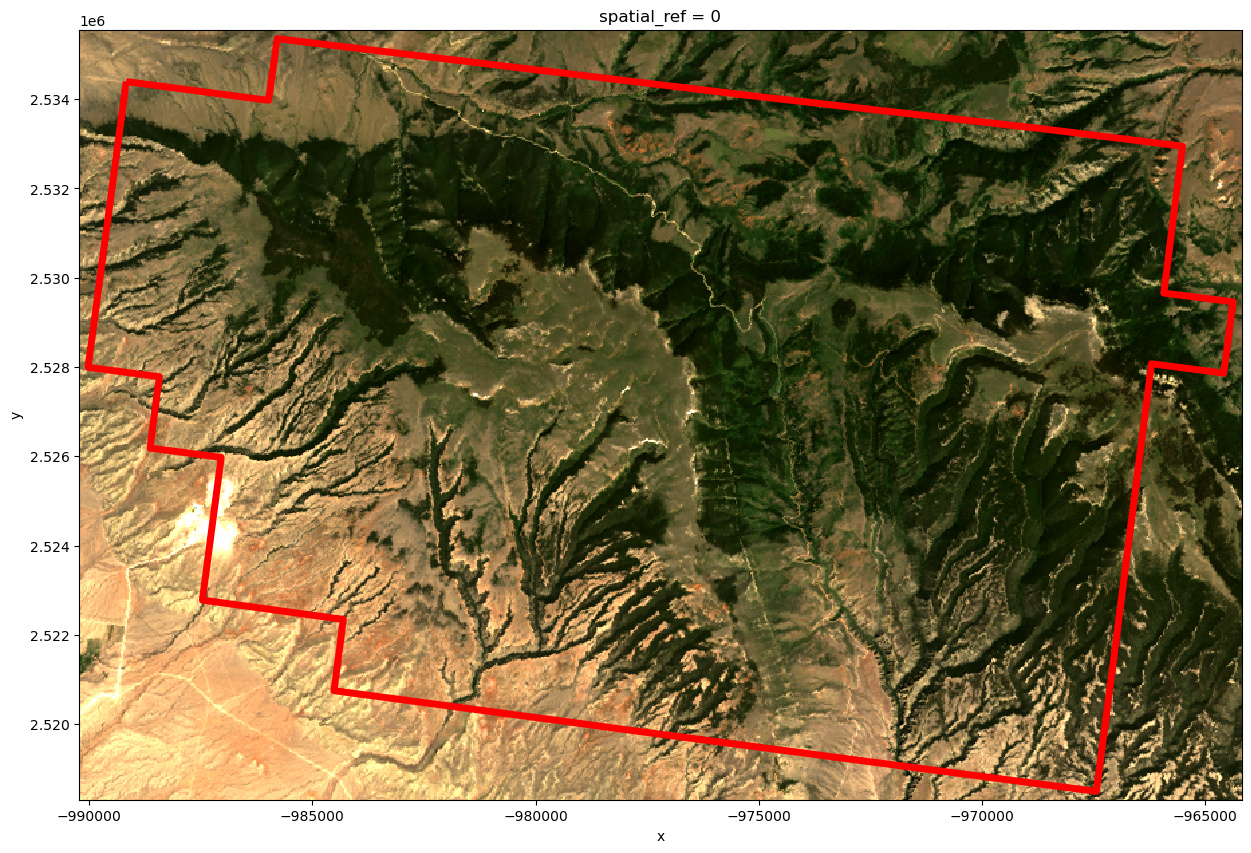

In [17]:
p=nf1p.plot(edgecolor='red',facecolor='none',figsize=(15,10),linewidth=5)
p=ls30s.get_bands([1,2,3]).xdata.plot.imshow(ax=p,robust=True)


__Figure 2.__ Overlay of Landsat 8 image subset (RGB bands) and the study area boundary outline in red.

### Step 2: Create convolution PCA model
Create definitions to sample the data, generate weights, and perform convolution analysis.

In [18]:
from sklearn.preprocessing import MinMaxScaler
import numba as nb
import xarray as xr

@nb.jit(nopython=True, nogil=True)
def _conv_pca(x,cmp_, m_, size):
    '''
    Performs the convolution given a array, component scores, means, and kernel size using dask's map_overlap function
    x=(numpy array) of data
    cmp_= (numpy array) component scores from sklearn PCA procedure
    m_= (numpy array) mean values from sklearn PCA procedure
    size= (int) width of the kernel

    returns a numpy array of correct shape for PCA transformation
    '''
    bnd,rws,clms=x.shape
    hs=int(size/2)
    outarr=np.empty((cmp_.shape[0],rws,clms))
    for ri in range(hs,rws-hs):
        sr=ri-hs
        for ci in range(hs,clms-hs):
            sc=ci-hs
            vls=x[:,sr:sr+size,sc:sc+size].flatten()
            for b in range(cmp_.shape[0]):
                vls2=((vls-m_)*cmp_[b,:]).sum() #removed the centering piece in standard scaler it is done here
                outarr[b,ri,ci]=vls2

    return outarr


@nb.jit(nopython=True, nogil=True)
def _expand_pnts_for_kernel(isys,isxs,wsize):
    '''
    Extracts values for kernel cells. Cells indices falling on the boundary of the image are moved in one index value.
    isys=array of row index locations
    isxs=array of column index locations
    wsize=width of the kernel
    
    returns two new lists of index values kernel cell locations that can be used to extract coordinate from an xarray data array
    '''
    hw=int(wsize/2)
    isys2=np.zeros(isys.shape[0]*wsize*wsize,dtype='int32')
    isxs2=np.zeros(isxs.shape[0]*wsize*wsize,dtype='int32')
    cnt=0
    for r in range(isys.shape[0]):
        rvl=isys[r]
        cvl=isxs[r]
        rvlm=rvl-hw
        for r2 in range(wsize):
            nr=rvlm+r2
            cvlm=cvl-hw
            for c2 in range(wsize):
                nc=cvlm+c2
                isys2[cnt]=nr
                isxs2[cnt]=nc
                cnt+=1

    return isys2,isxs2


def _sys_sample_image(rs,p,wsize=1):
    '''
    Creates a systematic sample of an image given a percent of cells sampled.
    rs = Raster object to be sampled
    p = percent of pixels to sample
    wsize=(int) width of a square kernel in cells if using convolution type analyses

    returns a 2d array of cell values rows=point centroid columns= band values
    if using kernels columns correspond to kernel cell values for each point
    '''
    bnds,rws,clms=rs.shape
    psq=np.sqrt(p)
    sr=int(rws/(rws*psq))
    sc=int(clms/(clms*psq))
    rstr=int(np.random.rand()*sr)
    rstc=int(np.random.rand()*sc)

    isys=np.arange(rstr+wsize,rws-wsize,sr)
    isxs=np.arange(rstc+wsize,clms-wsize,sc)
    rws=isys.shape[0]
    clms=isxs.shape[0]
    
    isxs,isys=np.meshgrid(isxs,isys)
    isxs=isxs.flatten()
    isys=isys.flatten()

    if(wsize>1):
        isys,isxs=_expand_pnts_for_kernel(isys,isxs,wsize)

    sel=rs.xdata.isel(x=xr.DataArray(isxs,dims='loc'),y=xr.DataArray(isys,dims='loc'))
    vls=sel.values.reshape((sel.shape[0],rws*clms,wsize*wsize))
    vls=np.moveaxis(vls,1,0).reshape(rws*clms,sel.shape[0]*wsize*wsize)

    df=pd.DataFrame(vls)
    vls=(df[df!=rs.null_value]).dropna().values

    return vls

def conv_pca(rs,prc=0.9,smp=0.01,ksize=0,output_bit_depth=None):
    '''
    determines convolution kernel weights for an optimal raster projection and returns a transformed raster
    using those weights. Weights are derived from a PCA analysis of each kernel cell value. Kernel cell
    values are extracted for each band in the rs stack.

    rs=(Raster) input raster object
    wsize=(int) window diameter for a square kernel measured in cells
    prc=(float) the proportion of variation in the data kept in the final raster dataset (0-1)
    smp=(float) the proportion of data used to build the transformation (training data - systematic random sample of location)
    ksize=(int) kernel width to use measured in cells
    output_bit_depths=(int) optional parameter used to scale the analysis outputs to a specified bit depth (e.g., 8,16,32).
    By default (None) output values will not be scaled

    returns a projected raster object and the pca object
    '''
    #scale values using a sample
    vls=_sys_sample_image(rs,p=smp)
    ss=StandardScaler(with_mean=False)
    ss.fit(vls)

    #apply the scaling to the input raster
    ss_mdl = general.ModelPredictAdaptor(ss,'transform')
    nch=(rs.nbands,*rs.xdata.chunks[1:])
    sc_pred_rs=rs.model_predict(ss_mdl,rs.nbands).chunk(nch)

    #perform pca using a sample of the scaled raster values
    vls2=_sys_sample_image(sc_pred_rs,p=smp,wsize=ksize)
    
    pca=PCA()
    pca.fit(vls2)
    #determine number of components to use
    ev=pca.explained_variance_ratio_
    sev=0
    for i in range(ev.shape[0]):
        e=ev[i]
        sev+=e
        if sev>prc:
            break
    kc=i+1 #add one to address 0 start

    #extract component scores for _conv_pca method
    kdf=pca.components_[0:kc,:] #scores,component (rows have weightings)
    hw=int(ksize/2)

    nch=sc_pred_rs.data.chunks
    och=list(nch)
    och[0]=(kc,)
    och[1]=tuple(np.array(och[1])+hw*2)
    och[2]=tuple(np.array(och[2])+hw*2)

    #apply _conv_pca to map_overlap function
    darr=sc_pred_rs.data.map_overlap(
        _conv_pca,
        depth={0: 0, 1: hw, 2: hw},
        chunks=och,
        boundary=np.nan,
        dtype='f8',
        meta=np.array((),dtype='f8'),
        cmp_=kdf,
        m_=pca.mean_,
        size=ksize
    )
    #convert dask array back to a raster
    cmp_rs=raster.data_to_raster(darr,x=sc_pred_rs.x,y=sc_pred_rs.y,affine=sc_pred_rs.affine,crs=sc_pred_rs.crs,nv=sc_pred_rs.null_value).chunk((1,*darr.chunks[1:]))

    #scale projected raster to bit depth if specified
    mmsc=''
    if(not output_bit_depth is None):
        pcasvls=pca.transform(vls2)[:,0:kc]
        mmsc=MinMaxScaler()
        mmsc.fit(pcasvls)
        mmsc_mdl=general.ModelPredictAdaptor(mmsc,'transform')
        cmp_rs=(cmp_rs.model_predict(mmsc_mdl,cmp_rs.nbands)*(2**output_bit_depth-1)).astype('uint'+str(output_bit_depth))

    return cmp_rs,pca



### Step 3: Apply the convolution PCA

In [19]:
#perform the pca convolution process on the landsat image; kernel size 5 by 5, output bit depth 16.
# This can be any size kernel. I have tried up to a 15 by 15.
ksize=5
conv_rs,pca=conv_pca(ls30s,prc=0.95,smp=0.1,ksize=ksize,output_bit_depth=16)

c:\Users\jshogland\AppData\Local\miniconda3\envs\rstools\lib\site-packages\raster_tools\raster.py:1689: UserWarning:

The null value -999999.0 could not be cast to uint16. It has been automatically changed to 9999



## Results
### Using our described approach, we accounted for 95% of the variation within the image using the first 10 principal components (Figure 3). Component convolution kernel weights (Display 1) highlight the linear relationships among both Landsat image bands and neighboring kernel cell values. For a random systematic sample of approximately 10% of the first 3 component values, unique clusters of information with varying trends appear in component space (Figure 4). 
### To transform our Landsat 8 image into 10 independent component surfaces (ICSs; Figure 5) required processing 70, 5 by 5 convolution kernels. T

### - % variation explained in each band (component) of the transformed image (Figure 3).
#### The number of bands correspond to the number of components that account for 95% of the variation in the 5 by 5 convolved image. Note that most of the variation/information in the data is explained in the first 3 components

Total % variance explained in components = 0.9513705345564717


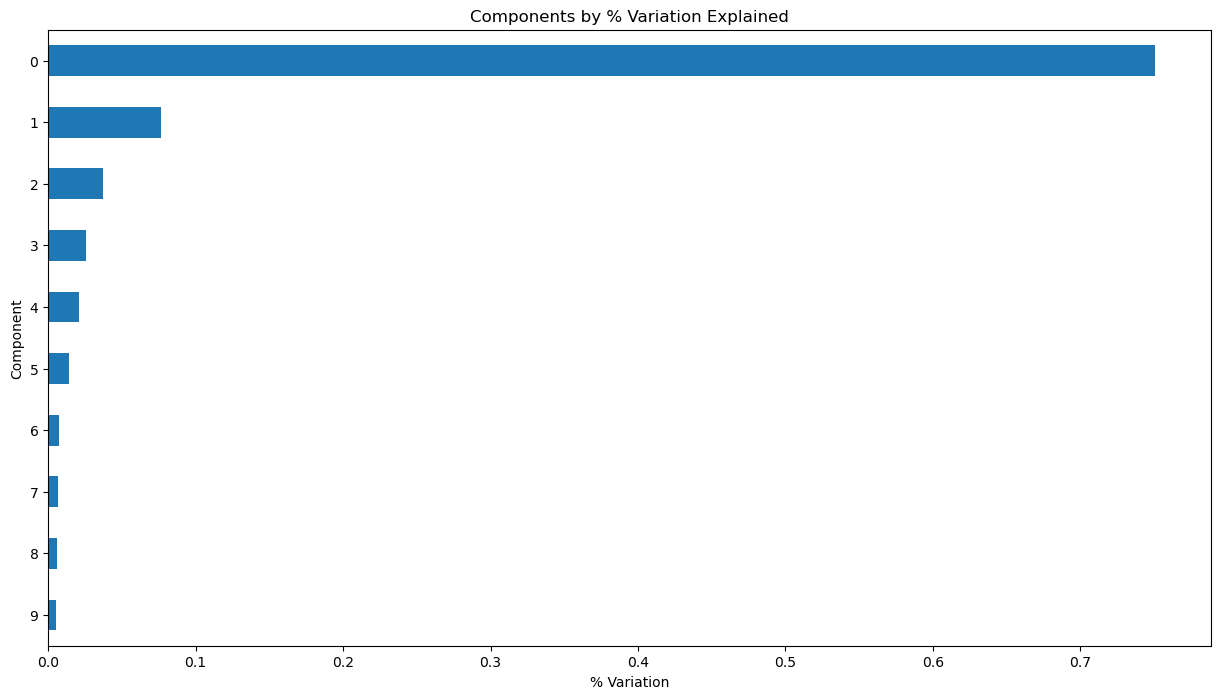

In [20]:
var_exp=pd.DataFrame(pca.explained_variance_ratio_[:conv_rs.nbands])
print('Total % variance explained in components =',var_exp.sum().values[0])
p=var_exp.plot(kind='barh',title='Components by % Variation Explained', xlabel='% Variation', ylabel='Component', figsize=(15,8),legend=False).invert_yaxis()
p

__Figure 3.__ Proportion of variation explained in each principal component. 

### - Look at the kernel weights for each selected component (Display 1).
#### Each component is made of the summation of 7 convolution kernels with the following weights. Convolution weights are applied to the centered and scaled input surface values of each band within the specified kernel of the input raster surface (ls30s in our example).

In [21]:
kw=pca.components_[0:conv_rs.nbands,:]
for k in range(kw.shape[0]):
    krs=kw[k].reshape((ls30s.nbands,ksize,ksize))
    print('\nWeights for component',k)
    for b in ls30s.band:
        print('Band =',b)
        print(pd.DataFrame(krs[b-1]))


Weights for component 0
Band = 1
          0         1         2         3         4
0  0.076997  0.078634  0.079622  0.079654  0.078665
1  0.079039  0.080879  0.081559  0.081142  0.079677
2  0.080512  0.081958  0.082248  0.081599  0.079468
3  0.080634  0.081591  0.081622  0.080341  0.078125
4  0.079437  0.079966  0.079428  0.078038  0.076069
Band = 2
          0         1         2         3         4
0  0.076110  0.077874  0.078986  0.079099  0.078101
1  0.078344  0.080387  0.081127  0.080745  0.079289
2  0.080042  0.081638  0.082010  0.081368  0.079137
3  0.080272  0.081345  0.081429  0.080114  0.077787
4  0.079045  0.079687  0.079135  0.077685  0.075639
Band = 3
          0         1         2         3         4
0  0.076268  0.078011  0.079043  0.079040  0.078066
1  0.078407  0.080395  0.081017  0.080615  0.079173
2  0.079942  0.081507  0.081825  0.081132  0.078999
3  0.080059  0.081135  0.081201  0.079860  0.077642
4  0.078852  0.079499  0.078929  0.077515  0.075575
Band = 4
   

__Display 1.__ Kernel weights for each component of the PCA convolution.

### - Look at a 3d plot of the first 3 components for systematic random locations using 10% of the data. (Figure 4)

In [22]:
import plotly.express as px
#get a sample of the PCA convolution raster values
vls=_sys_sample_image(conv_rs,0.1,1) 
df=pd.DataFrame(vls)
print('n =', df.shape[0])
fig = px.scatter_3d(df, x=0, y=1, z=2
              ,width=1500,height=800)

fig.show()


n = 55197


__Figure 4.__ A 3 dimensional representation of the first 3 principal components scores values for ~10% of the cell locations within the Landsat 8 image. 

### - Visualize the PCA convolution raster surfaces (Figure 5)

In [23]:
conv_rs.load()

<raster_tools.Raster (crs='EPSG:5070', masked=True)>
<xarray.DataArray 'raster' (band: 10, y: 575, x: 868)> Size: 10MB
dask.array<xarray-raster, shape=(10, 575, 868), dtype=uint16, chunksize=(1, 575, 868), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int32 40B 1 2 3 4 5 6 7 8 9 10
  * y            (y) float64 5kB 2.536e+06 2.536e+06 ... 2.518e+06 2.518e+06
  * x            (x) float64 7kB -9.902e+05 -9.902e+05 ... -9.642e+05 -9.642e+05
    spatial_ref  int32 4B 0
Attributes:
    _FillValue:  9999

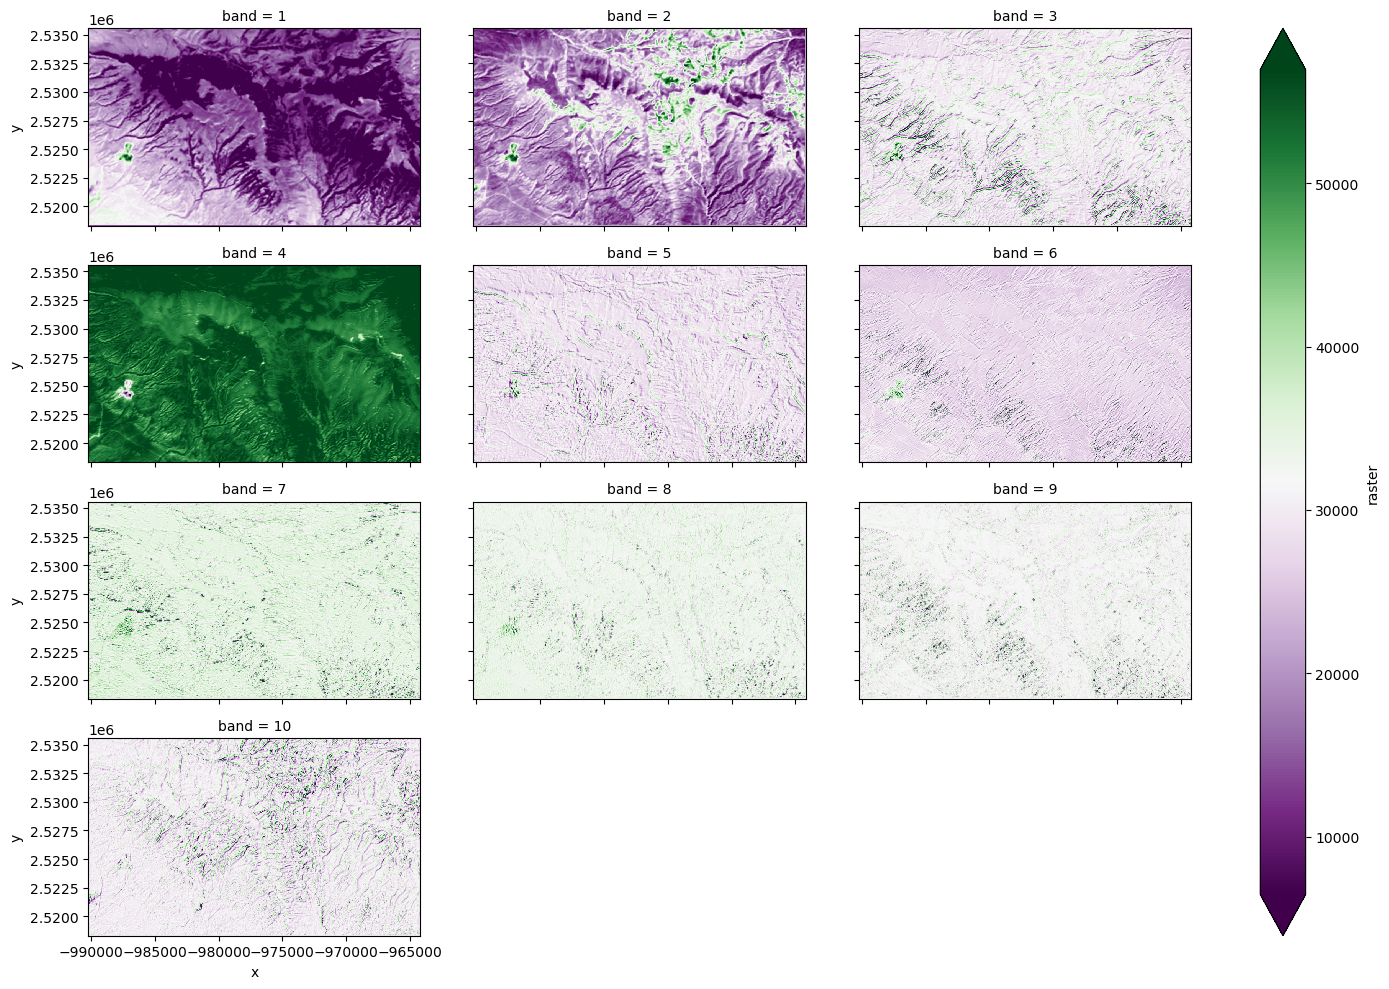

In [24]:
conv_rs.plot(x='x',y='y',col='band',col_wrap=3,figsize=(15,conv_rs.nbands),robust=True,cmap='PRGn')

__Figure 5.__ Independent component surfaces (ICSs) derived from a principal component analysis of values taken from a systematic sample of cell locations within a subset of a Landsat scene for a kernel size of five by five cells. The first eleven ICSs account for a more than 95% of the variance within the data.    

## Discussion
### In this notebook we have demonstrated how to use sampling, analysis windows, and PCA to project multi-band raster data into independent component space (Figure 4) that highlights various orthogonal aspects of the input data while simultaneously reducing the dimensionality of the data. The results of our analysis emphasize both hue and textural aspects of the data within each principal components. While kernel cell weights provide unique insights into the linear relationships among image bands and neighbor cell values, when combined with Raster Tools processing architecture they can be used to produce ICSs (Figure 5) that spatially emphasize independent hue and textural aspects of the input data.                   

## Conclusion
### The described approach is quick and mathematically determines kernel weights such that each band in the convolved output image is independent of the other band values. Moreover, the process removes all redundant information across bands and within kernel cell values, which is also desirable. These surfaces should make for effective predictor variables and\or should make it easy to spread and balance a sample across all the hue and textural information within a defined analysis window, for a given raster dataset.    
 